# Grado en Ingeniería Informática
### **Asignatura**: Tratamiento de Señales Visuales/Tratamiento de Señales Multimedia I
### Práctica 4: Reconocimiento de escenas con Deep Learning

#### Pregunta 5

---

Autor: Rodrigo Juez Hernández (rodrigo.juezh@estudiante.uam.es), Universidad Autónoma de Madrid


# 0. Valores a probar en esta pregunta

In [ ]:
BEST_IMG_SIZE = 224
BEST_BATCH_SIZE = 8 # numero de elementos procesados conjuntamente en cada iteracion
BEST_ACTIVATION = "relu"
EPOCHS = 15 # numero de epocas para entrenamiento

# 1. Entorno
(Ejecuta una vez y compacta para que no moleste)

#### Entorno de trabajo
Instalación de librerías, comprobación de versiones, carga de dataset y elección de hardware.

In [ ]:
#%%capture
#%tensorflow_version 2.x
!pip install tensorflow==2.3.0
import tensorflow as tf
import numpy as np
import os, subprocess, pathlib, time
from google.colab import drive
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers


In [ ]:
!python --version                     # mostrar version de python
print('Tensorflow ' + tf.__version__) # mostrar version tensorflow


# Montar Google Drive y crear carpetas
drive.mount('/content/gdrive', force_remount=True)

work_dir = '/content/work_dir'                    # directorio de trabajo en local (mas rapido)
dwld_dir = '/content/gdrive/My Drive/dwld_dir'    # directorio de descarga en Google drive personal
subprocess.call(["mkdir","-p",work_dir])          # crear directorio para trabajo
subprocess.call(["mkdir","-p",dwld_dir+'/dataset/'])  # crear directorio para dataset

os.chdir(dwld_dir+'/dataset/')                        # posicionarse en el directorio
# Descargar dataset scenes15 si no esta disponible
if os.path.isfile('./dataset_scenes15.zip') == False: 
  !wget http://www-vpu.eps.uam.es/~jcs/tsv/dataset_scenes15.zip 
  
# Copiar el dataset al directorio local (mayor velocidad de lectura que en Gdrive)
!cp /content/gdrive/My\ Drive/dwld_dir/dataset/dataset_scenes15.zip /content/work_dir/

os.chdir(work_dir)                        # posicionarse en el directorio
if os.path.isdir('./scenes15') == False: 
  !unzip -o -q dataset_scenes15.zip -d .

print('El dataset se encuentra descargado en el directorio {} \ny descomprimido en el directorio {} (usado para lectura de datos)'.format(dwld_dir, work_dir))

In [ ]:
dataset_dir = pathlib.Path(work_dir + '/scenes15/')

# Obtener etiquetas de clase y numero de clases
CLASS_NAMES = np.array([item.name for item in dataset_dir.glob('*')]) #clases son subdirectorios de '/train/'
NUM_CLASSES = len(CLASS_NAMES) # numero total de clases

# 2. Preparación pregunta
Funciones para que instancian el generador, y el modelo para llamarlas reiteradamente.

#### Preparar dataset

In [ ]:
def generator_dataset(BATCH_SIZE = 16, IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3):  
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.20)

  # Obtenemos un iterador sobre los datos de entrenamiento del dataset
  # aplicando el ImageDataGenerator creado anteriormente

  train_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE, 
                                            subset="training",                                         
                                            shuffle=True,
                                            seed=0)

  test_data_gen = img_gen.flow_from_directory(directory=str(dataset_dir),
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            color_mode='rgb',                                                     
                                            classes = list(CLASS_NAMES),
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            subset="validation",
                                            shuffle=True,
                                            seed=0)
  
  return train_data_gen, test_data_gen


# 3. Modelos Propuestos
Funciones que instancian los modelos que he propuesto para esta pregunta.
No todos los modelos que creemos aquí van a ser ejecutados, hemos hecho pruebas y finalmente hemos considerado los que si que vamos a incluir en el apartado de Ejecución.



## Modelos Base

#### Modelo Tutorial

In [60]:
def model_DEFAULT_ADAM(IMG_HEIGHT = 224, IMG_WIDTH = 224, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=120, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=84, activation=ACTIVATION))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model
model_DEFAULT_ADAM(print_summary = True)

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 222, 222, 6)       168       
_________________________________________________________________
average_pooling2d_129 (Avera (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 109, 109, 16)      880       
_________________________________________________________________
average_pooling2d_130 (Avera (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 46656)             0         
_________________________________________________________________
dense_190 (Dense)            (None, 120)               5598840   
_________________________________________________________________
dense_191 (Dense)            (None, 84)              

#### Modelo DROPOUT

In [61]:
def model_DROPOUT(IMG_HEIGHT = 224, IMG_WIDTH = 224, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=16, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())
  

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))

  # incluir fully convolutional F5
  model.add(layers.Dense(units=120, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=84, activation=ACTIVATION))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model

#### Modelo VGG16
Lo implementé para ver si funcionaba bien, pero tiene un rendimiento pésimo osea uqe no lo hemos incluido en las métricas finales.

In [62]:
def model_VGG16(IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=64, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))
  
  model.add(layers.Conv2D(filters=64, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))
  

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=128, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=128, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  model.add(layers.Conv2D(filters=256, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=256, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.AveragePooling2D())

  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.AveragePooling2D())

  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))
  
  model.add(layers.Conv2D(filters=512, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))


  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=4096, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=4096, activation=ACTIVATION))
  
  model.add(layers.Dense(units=1000, activation=ACTIVATION))


  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model

## Modelos derivados del original que vamos a probar

#### Modelo Aumenta Complejidad
Hemos seguido la misma proporcion de que la segunda capa convolucional tenga 2.67 veces el número de filtros que la primera ya que así estaba en la red original y en AlexNET, hemos aumentado el tamaño de filtros para que tenga más visión y hemos aumentado los parametros del clasificador para que se ajuste más.

Cambios:
* C1 tamaño del número de filtros aumentado a 12
* C3 tamaño del número de filtros aumentado a 32
* F5 unidades de la capa oculta fully connected aumentadas a 240
* F6 unidades de la capa oculta fully connected aumentadas a 168

In [63]:
def model_MAS_COMPLEJ(IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=12, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=32, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=240, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=168, activation=ACTIVATION))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model


model_MAS_COMPLEJ(print_summary = True)

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 30, 30, 12)        336       
_________________________________________________________________
average_pooling2d_131 (Avera (None, 15, 15, 12)        0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 13, 13, 32)        3488      
_________________________________________________________________
average_pooling2d_132 (Avera (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_193 (Dense)            (None, 240)               276720    
_________________________________________________________________
dense_194 (Dense)            (None, 168)             

#### Modelo Disminuye Complejidad


Cambios:
no he tocado el tamaño del filtro porque 3x3 ya me parecia ridiculamente pequeño
* C3 cantidad de filtros disminuida de 16 a 12
* F5 unidades de la capa oculta fully connected disminuidas a 84
* F6 unidades de la capa oculta fully connected disminuidas a 60

In [64]:
def model_MENOS_COMPLEJ(IMG_HEIGHT = 32, IMG_WIDTH = 32, IMG_CHANNELS = 3, ACTIVATION = "relu", print_summary = False):  
  # definir modelo de red
  model = models.Sequential()

  # incluir capa convolucional C1
  model.add(layers.Conv2D(filters=6, 
                          kernel_size=(3, 3), 
                          strides = (1,1),
                          padding = 'valid',
                          activation=ACTIVATION, 
                          input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)))

  # incluir average pooling S2
  model.add(layers.AveragePooling2D())

  # incluir capa convolucional C3
  model.add(layers.Conv2D(filters=12, 
                          kernel_size=(3, 3),
                          strides = (1,1),
                          padding = 'valid', 
                          activation=ACTIVATION))

  # incluir average pooling S4
  model.add(layers.AveragePooling2D())

  # convertir el volumen de datos en vector fila para conectarlo con capa FC
  model.add(layers.Flatten())

  # incluir fully convolutional F5
  model.add(layers.Dense(units=84, activation=ACTIVATION))

  # incluir fully convolutional F6
  model.add(layers.Dense(units=60, activation=ACTIVATION))

  # incluir salida OUTPUT
  model.add(layers.Dense(units=NUM_CLASSES, activation = 'softmax'))


  # mostar resumen
  if print_summary == True:
    model.summary()


  # definicion con optimizador con valores definidos por el usuario
  LEARNING_RATE = 0.001 # factor de aprendizaje
  model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),            
              loss='categorical_crossentropy',            
              metrics=['accuracy'])

  return model


model_MENOS_COMPLEJ(print_summary = True)

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_133 (Avera (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 13, 13, 12)        660       
_________________________________________________________________
average_pooling2d_134 (Avera (None, 6, 6, 12)          0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 432)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 84)                36372     
_________________________________________________________________
dense_197 (Dense)            (None, 60)              

# 4. Ejecución

In [65]:
IMG_CHANNELS = 3

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

train_loss_list = []
train_acc_list = []

history_acc_list = []
history_val_acc_list = []
history_loss_list = []
history_val_loss_list = []


models_tested = {
    "MAS_COMPLEJO": model_MAS_COMPLEJ(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False),
    
    "MENOS_COMPLEJO": model_MENOS_COMPLEJ(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False),

    "TUTORIAL_ADAM": model_DEFAULT_ADAM(IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS, print_summary = False)


  }


for model_name, model in models_tested.items():
  print(f"{'='*10} INICIANDO MODEL con NOMBRE {model_name} {'='*10}")
  
  train_data_gen, test_data_gen = generator_dataset(BATCH_SIZE = BEST_BATCH_SIZE, IMG_HEIGHT = BEST_IMG_SIZE, IMG_WIDTH = BEST_IMG_SIZE, IMG_CHANNELS = IMG_CHANNELS)

  with tf.device('/GPU:0'):
    history = model.fit_generator(
        generator=train_data_gen,          
        steps_per_epoch=train_data_gen.n // BEST_BATCH_SIZE,      
        validation_data=test_data_gen,
        validation_steps=test_data_gen.n // BEST_BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1     
    )


    
  
        
    test_loss, test_acc = model.evaluate_generator( generator=test_data_gen, 
                                                    steps = test_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

    train_loss, train_acc = model.evaluate_generator( generator=train_data_gen, 
                                                    steps = train_data_gen.n // BEST_BATCH_SIZE, 
                                                    verbose=1)

  


  ############### APARTIR DE AQUÍ ES PARA DEBUGEAR Y GUARDAR RESULTADOS
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)

  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  history_acc_list.append(history.history['accuracy']         )
  history_val_acc_list.append(history.history['val_accuracy'] )

  history_loss_list.append(history.history['loss']            )
  history_val_loss_list.append(history.history['val_loss']    )


  ################# POR SI SE DESCONECTA A LA MITAD EL GOOGLE COLAB PODEMOS RECUPERAR PARTE DE LA EJECUCIÓN Y SOLO EJECUTAR LAS REDES QUE NO HAYAN TERMINADO
  print("test_loss_list = ", test_loss_list)
  print("test_acc_list = ", test_acc_list)

  print("train_loss_list = ", train_loss_list)
  print("train_acc_list = ", train_acc_list)

  print("history_acc_list = ", history_acc_list)
  print("history_val_acc_list = ", history_val_acc_list)
  print("history_loss_list = ", history_loss_list)
  print("history_val_loss_list = ", history_val_loss_list)
  
  

========== INICIANDO MODEL con NOMBRE MAS_COMPLEJO ==========
Found 3592 images belonging to 15 classes.
Found 893 images belonging to 15 classes.
Epoch 1/15
449/449 [==============================] - 14s 31ms/step - loss: 2.2298 - accuracy: 0.2689 - val_loss: 1.9420 - val_accuracy: 0.3491
Epoch 2/15
449/449 [==============================] - 13s 29ms/step - loss: 1.3626 - accuracy: 0.5384 - val_loss: 1.6527 - val_accuracy: 0.4392
Epoch 3/15
449/449 [==============================] - 14s 32ms/step - loss: 0.6576 - accuracy: 0.7815 - val_loss: 1.6300 - val_accuracy: 0.4899
Epoch 4/15
449/449 [==============================] - 13s 30ms/step - loss: 0.2405 - accuracy: 0.9248 - val_loss: 1.8944 - val_accuracy: 0.5101
Epoch 5/15
449/449 [==============================] - 13s 29ms/step - loss: 0.0991 - accuracy: 0.9708 - val_loss: 2.3031 - val_accuracy: 0.4673
Epoch 6/15
449/449 [==============================] - 14s 31ms/step - loss: 0.0657 - accuracy: 0.9808 - val_loss: 2.4936 - val_accura

# 5. Plotting resultados

In [66]:
print(models_tested.keys())
print("test_loss_list = ", test_loss_list)
print("test_acc_list = ", test_acc_list)

print("train_loss_list = ", train_loss_list)
print("train_acc_list = ", train_acc_list)

print("history_acc_list = ", history_acc_list)
print("history_val_acc_list = ", history_val_acc_list)
print("history_loss_list = ", history_loss_list)
print("history_val_loss_list = ", history_val_loss_list)

dict_keys(['MAS_COMPLEJO', 'MENOS_COMPLEJO', 'TUTORIAL_ADAM'])
test_loss_list =  [3.8055856227874756, 3.5492379665374756, 3.7102785110473633]
test_acc_list =  [0.4650900959968567, 0.5180180072784424, 0.42004504799842834]
train_loss_list =  [0.004157660994678736, 0.0026557378005236387, 0.03527523949742317]
train_acc_list =  [0.9991648197174072, 0.9997215867042542, 0.990256130695343]
history_acc_list =  [[0.26893097162246704, 0.538418710231781, 0.7814587950706482, 0.9248329401016235, 0.970768392086029, 0.9807906746864319, 0.980512261390686, 0.9905345439910889, 0.9849665760993958, 0.9866369962692261, 0.9755011200904846, 0.980512261390686, 0.993318498134613, 0.9922049045562744, 0.9874721765518188], [0.2614142596721649, 0.518930971622467, 0.695712685585022, 0.8460467457771301, 0.9370824098587036, 0.9718819856643677, 0.9741091132164001, 0.9869153499603271, 0.9930400848388672, 0.980512261390686, 0.9874721765518188, 0.9905345439910889, 0.9788418412208557, 0.9827394485473633, 0.9991648197174072

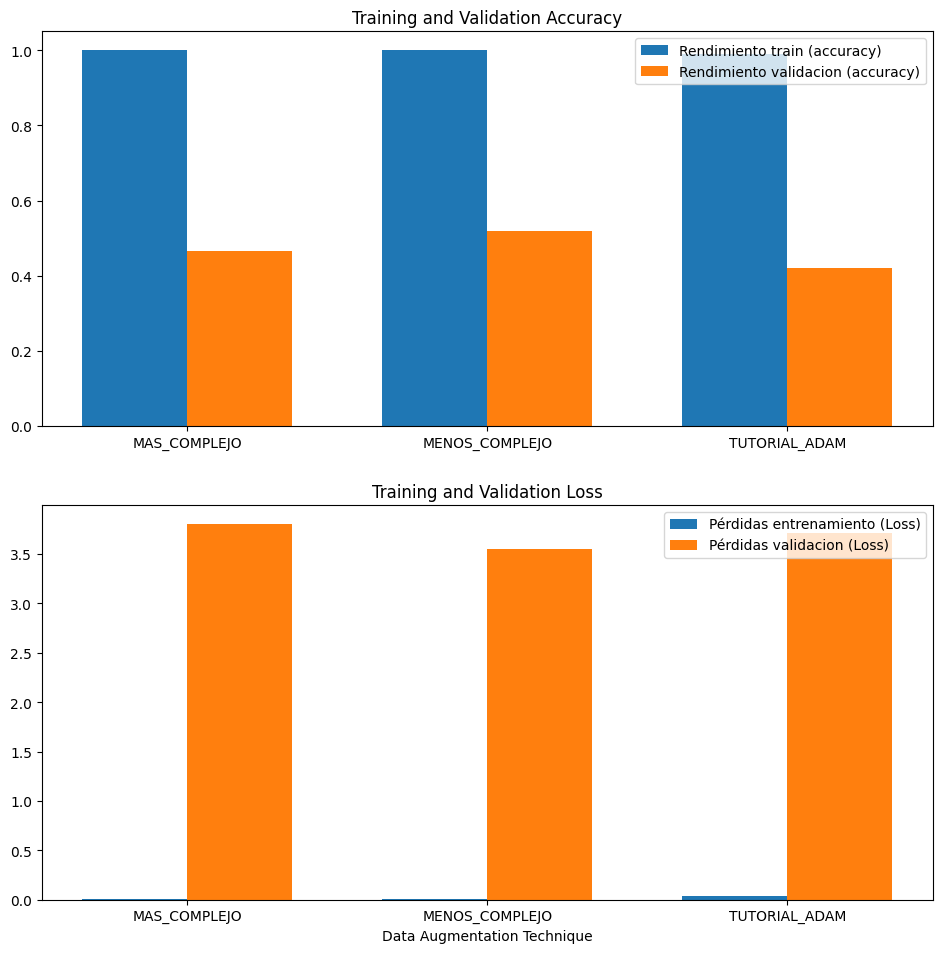

In [67]:
ind = np.arange(len(models_tested))
width = 0.35 

fig, axs = plt.subplots(2,1)
axs[0].bar(ind, train_acc_list,width,  label='Rendimiento train (accuracy)')
axs[0].bar(ind + width, test_acc_list,width,  label='Rendimiento validacion (accuracy)')
axs[0].legend(loc='upper right')
axs[0].set_title('Training and Validation Accuracy')

axs[0].set_xticks(ind + width / 2)
axs[0].set_xticklabels(models_tested)




axs[1].bar(ind, train_loss_list,width,  label='Pérdidas entrenamiento (Loss)')
axs[1].bar(ind + width, test_loss_list,width,  label='Pérdidas validacion (Loss)')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss')

axs[1].set_xticks(ind + width / 2)
axs[1].set_xticklabels(models_tested)
axs[1].set_xlabel('Data Augmentation Technique')


fig.set_size_inches(11.5, 11.5)
fig.set_dpi(100)
plt.show()

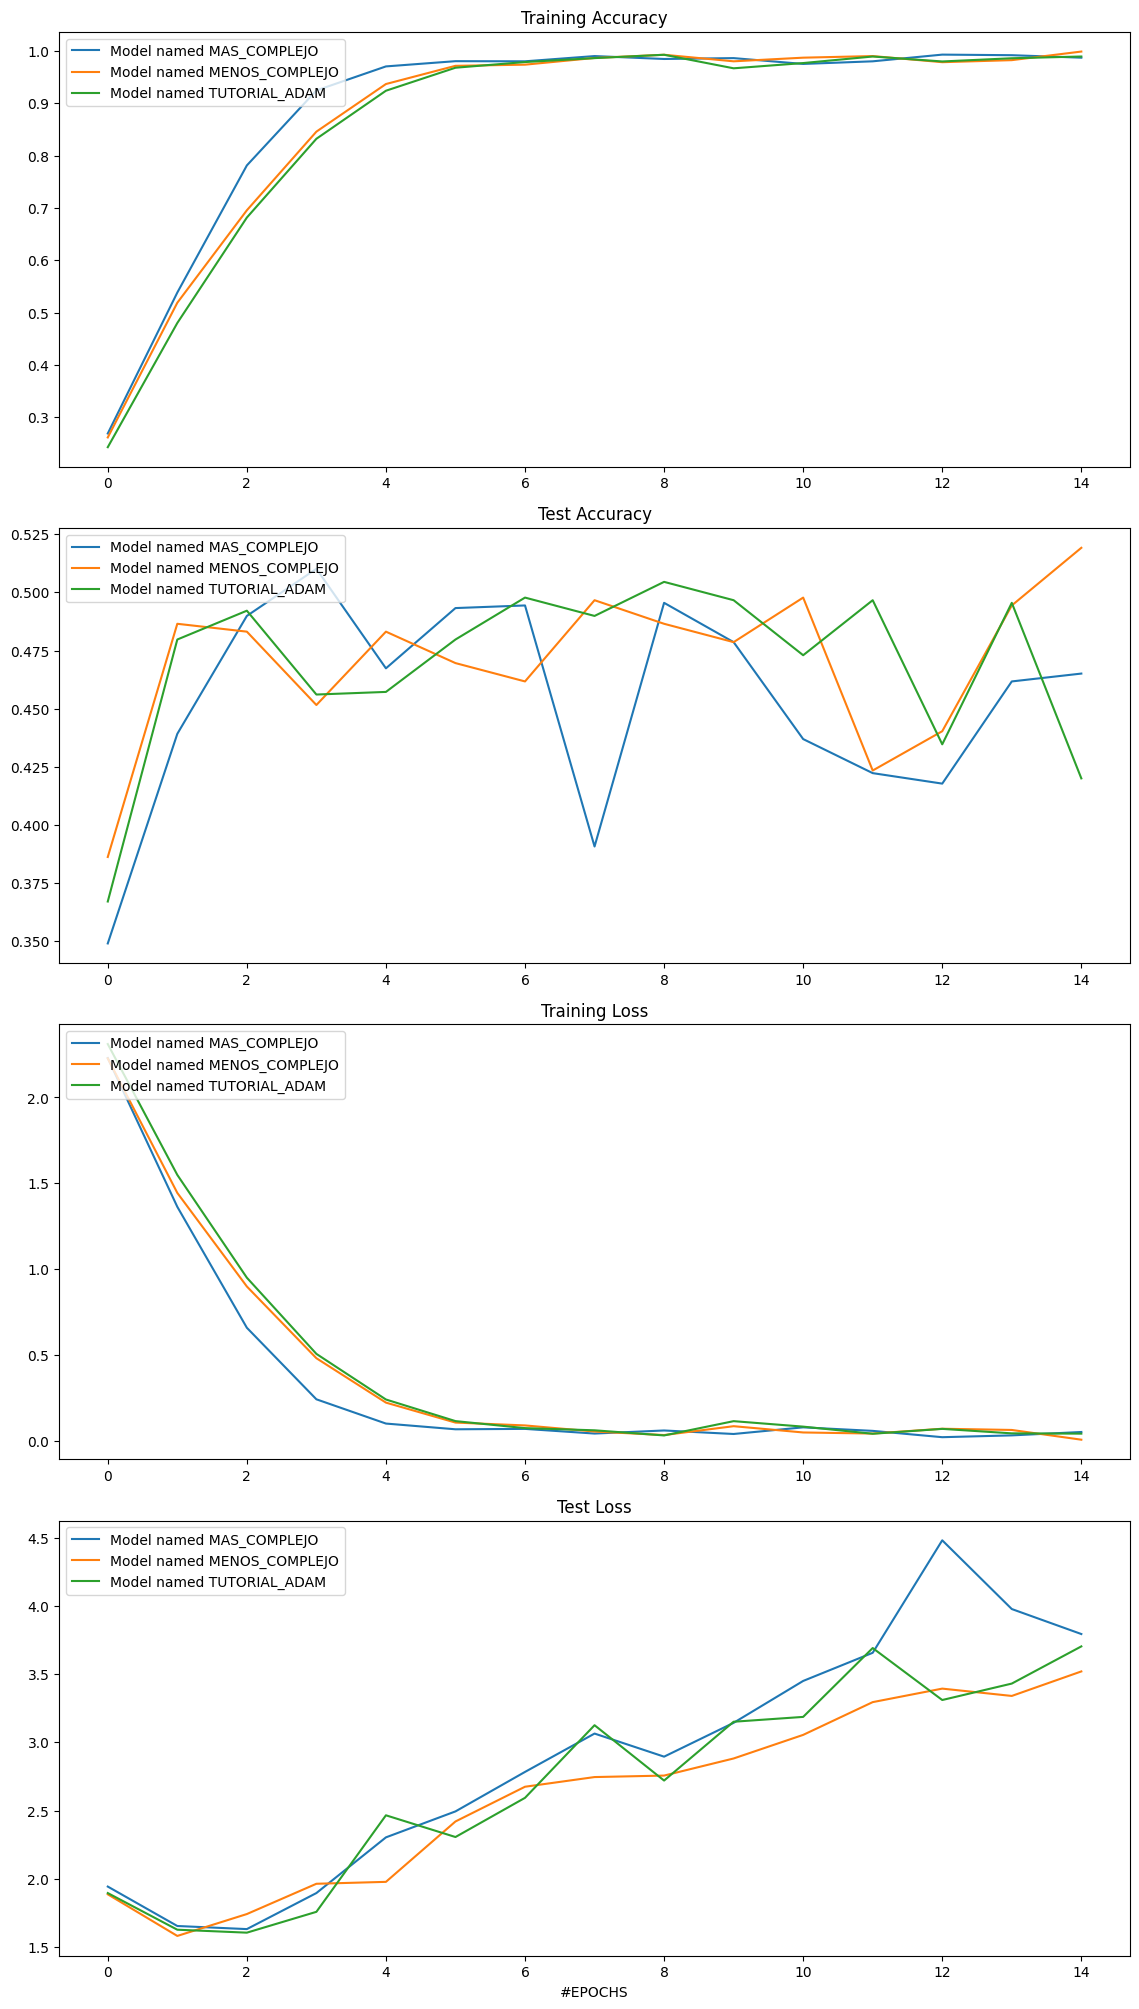

In [68]:
fig, axs = plt.subplots(4,1)
epoch_list = np.arange(EPOCHS)

for idx, batch_size in enumerate(models_tested):
  axs[0].plot(epoch_list, history_acc_list[idx],  label=f'Model named {batch_size}')
  axs[0].set_title(f'Training Accuracy')
  axs[0].legend(loc='upper left')

for idx, batch_size in enumerate(models_tested):
  axs[1].plot(epoch_list, history_val_acc_list[idx],  label=f'Model named {batch_size}')
  axs[1].set_title(f'Test Accuracy')
  axs[1].legend(loc='upper left')


for idx, batch_size in enumerate(models_tested):
  axs[2].plot(epoch_list, history_loss_list[idx],  label=f'Model named {batch_size}')
  axs[2].set_title(f'Training Loss')
  axs[2].legend(loc='upper left')


for idx, batch_size in enumerate(models_tested):
  axs[3].plot(epoch_list, history_val_loss_list[idx],  label=f'Model named {batch_size}')
  axs[3].set_title(f'Test Loss')
  axs[3].legend(loc='upper left')


  
  

fig.set_size_inches(11.5, 20)
fig.set_dpi(100)
plt.tight_layout()
plt.xlabel("#EPOCHS")
plt.show()